In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from focal_loss import SparseCategoricalFocalLoss

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2022-05-30 21:35:11.567400: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-30 21:35:11.567484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-05-30 21:35:11.569480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
data_path = '/home/shellygoel2324/data_clean.csv'
labels_path = '/home/shellygoel2324/processedLabels.csv'

In [17]:
def load_pose_landmarks(csv_path, labels_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    labels = pd.read_csv(labels_path, header=None)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')

    # Extract the labels
    y = labels
    classes = range(8)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes, dataframe

In [18]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path, labels_path)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2


print(X_train.shape)

(10255, 51)


In [19]:
print("TRAIN DISTRIBUTION")

sample_dist = []


for i in range(1,8):
    
    num_i = 0
    for ind, sample in enumerate(y_train):
            if tf.argmax(sample) == i:
                if i ==0:
                    print("HERE")
                
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)

    
print("\nTEST DISTRIBUTION")
for i in range(0,8):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                if i ==0:
                    print(sample)
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")


TRAIN DISTRIBUTION
1: 0.50931253047294
2: 0.24280838615309605
3: 0.11038517796196977
4: 0.04475865431496831
5: 0.02340321794246709
6: 0.008776206728425159
7: 0.060555826426133594

TEST DISTRIBUTION
0: 0.0
1: 0.5195007800312013
2: 0.24726989079563183
3: 0.09750390015600624
4: 0.039781591263650544
5: 0.0358814352574103
6: 0.0062402496099844
7: 0.05382215288611544


In [20]:
#sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

sample_weights = weight_balanced


In [21]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## No normalizing at all

In [23]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = no_normalization(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 51)]              0         
                                                                 
 reshape_1 (Reshape)         (None, 17, 3)             0         
                                                                 
 tf.__operators__.getitem_1   (None, 17, 2)            0         
 (SlicingOpLambda)                                               
                                                                 
 flatten_1 (Flatten)         (None, 34)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               4480      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

In [24]:
print(sample_weights)


sample_weights = sample_weights/np.linalg.norm(sample_weights)

print(sample_weights)


[1.9634309783649244, 4.118473895582329, 9.059187279151944, 22.342047930283222, 42.729166666666664, 113.94444444444444, 16.513687600644122]
[0.01567794 0.03288589 0.07233735 0.1784006  0.34119116 0.90984309
 0.13186132]


In [25]:
class_weights = {}
class_weights[0] = 0
for i in range(1,8):
    class_weights[i] = sample_weights[i-1]

In [26]:
print(class_weights)

{0: 0, 1: 0.01567793943728298, 2: 0.032885894650975495, 3: 0.07233734777467225, 4: 0.17840060496934418, 5: 0.34119115700387076, 6: 0.9098430853436554, 7: 0.1318613167164718}


In [30]:
#USING FOCAL LOSS

import tensorflow_addons as tfa


In [31]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.SigmoidFocalCrossEntropyWithClassWeightsNoNorm"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training

history = model.fit(X_train, y_train,class_weight= class_weights,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
628/641 [============================>.] - ETA: 0s - loss: 0.0920 - tp: 967.0000 - fp: 4886.0000 - tn: 65450.0000 - fn: 9081.0000 - accuracy: 0.8262 - precision: 0.1652 - recall: 0.0962 - auc: 0.5282 - prc: 0.1406
Epoch 1: val_loss improved from -inf to 0.41194, saving model to weights.SigmoidFocalCrossEntropyWithClassWeightsNoNorm


2022-05-30 21:43:50.894613: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.SigmoidFocalCrossEntropyWithClassWeightsNoNorm/assets
641/641 [==============================] - 6s 6ms/step - loss: 0.0907 - tp: 968.0000 - fp: 4897.0000 - tn: 66888.0000 - fn: 9287.0000 - accuracy: 0.8271 - precision: 0.1650 - recall: 0.0944 - auc: 0.5282 - prc: 0.1406 - val_loss: 0.4119 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8974.0000 - val_fn: 1282.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4245 - val_prc: 0.1354
Epoch 2/200
639/641 [============================>.] - ETA: 0s - loss: 0.0241 - tp: 28.0000 - fp: 158.0000 - tn: 71410.0000 - fn: 10196.0000 - accuracy: 0.8734 - precision: 0.1505 - recall: 0.0027 - auc: 0.4973 - prc: 0.1311
Epoch 2: val_loss did not improve from 0.41194
641/641 [==============================] - 2s 3ms/step - loss: 0.0241 - tp: 28.0000 - fp: 159.0000 - tn: 71626.0000 - fn: 10227.0000 - accuracy: 0.8734 - precision: 0.1497 - recall: 0.0027 - auc: 0.49

Epoch 13/200
640/641 [============================>.] - ETA: 0s - loss: 0.0204 - tp: 1.0000 - fp: 11.0000 - tn: 71669.0000 - fn: 10239.0000 - accuracy: 0.8749 - precision: 0.0833 - recall: 9.7656e-05 - auc: 0.6134 - prc: 0.1542
Epoch 13: val_loss did not improve from 0.41194
641/641 [==============================] - 2s 3ms/step - loss: 0.0204 - tp: 1.0000 - fp: 11.0000 - tn: 71774.0000 - fn: 10254.0000 - accuracy: 0.8749 - precision: 0.0833 - recall: 9.7513e-05 - auc: 0.6133 - prc: 0.1542 - val_loss: 0.3618 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8974.0000 - val_fn: 1282.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4951 - val_prc: 0.1119
Epoch 14/200
623/641 [============================>.] - ETA: 0s - loss: 0.0203 - tp: 3.0000 - fp: 24.0000 - tn: 69752.0000 - fn: 9965.0000 - accuracy: 0.8747 - precision: 0.1111 - recall: 3.0096e-04 - auc: 0.5949 - prc: 0.1447
Epoch 14: val_loss did not improve from 0.41194
641/641 [========

Epoch 25/200
639/641 [============================>.] - ETA: 0s - loss: 0.0196 - tp: 13.0000 - fp: 53.0000 - tn: 71515.0000 - fn: 10211.0000 - accuracy: 0.8745 - precision: 0.1970 - recall: 0.0013 - auc: 0.6032 - prc: 0.1468
Epoch 25: val_loss did not improve from 0.41194
641/641 [==============================] - 2s 3ms/step - loss: 0.0196 - tp: 13.0000 - fp: 53.0000 - tn: 71732.0000 - fn: 10242.0000 - accuracy: 0.8745 - precision: 0.1970 - recall: 0.0013 - auc: 0.6028 - prc: 0.1467 - val_loss: 0.3599 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8974.0000 - val_fn: 1282.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4806 - val_prc: 0.1095
Epoch 26/200
624/641 [============================>.] - ETA: 0s - loss: 0.0195 - tp: 20.0000 - fp: 44.0000 - tn: 69844.0000 - fn: 9964.0000 - accuracy: 0.8747 - precision: 0.3125 - recall: 0.0020 - auc: 0.6191 - prc: 0.1516
Epoch 26: val_loss did not improve from 0.41194
641/641 [=================

Epoch 37/200
630/641 [============================>.] - ETA: 0s - loss: 0.0202 - tp: 1.0000 - fp: 50.0000 - tn: 70510.0000 - fn: 10079.0000 - accuracy: 0.8744 - precision: 0.0196 - recall: 9.9206e-05 - auc: 0.6085 - prc: 0.1435   
Epoch 37: val_loss did not improve from 0.41194
641/641 [==============================] - 2s 3ms/step - loss: 0.0203 - tp: 1.0000 - fp: 50.0000 - tn: 71735.0000 - fn: 10254.0000 - accuracy: 0.8744 - precision: 0.0196 - recall: 9.7513e-05 - auc: 0.6073 - prc: 0.1431 - val_loss: 0.3666 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8974.0000 - val_fn: 1282.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5024 - val_prc: 0.1158
Epoch 38/200
625/641 [============================>.] - ETA: 0s - loss: 0.0201 - tp: 4.0000 - fp: 44.0000 - tn: 69956.0000 - fn: 9996.0000 - accuracy: 0.8745 - precision: 0.0833 - recall: 4.0000e-04 - auc: 0.6013 - prc: 0.1393
Epoch 38: val_loss did not improve from 0.41194
641/641 [=====

Epoch 49/200
637/641 [============================>.] - ETA: 0s - loss: 0.0201 - tp: 12.0000 - fp: 96.0000 - tn: 71248.0000 - fn: 10180.0000 - accuracy: 0.8740 - precision: 0.1111 - recall: 0.0012 - auc: 0.6224 - prc: 0.1517
Epoch 49: val_loss did not improve from 0.41194
641/641 [==============================] - 2s 3ms/step - loss: 0.0200 - tp: 12.0000 - fp: 96.0000 - tn: 71689.0000 - fn: 10243.0000 - accuracy: 0.8740 - precision: 0.1111 - recall: 0.0012 - auc: 0.6226 - prc: 0.1518 - val_loss: 0.3590 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8974.0000 - val_fn: 1282.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6725 - val_prc: 0.1767
Epoch 50/200
635/641 [============================>.] - ETA: 0s - loss: 0.0201 - tp: 1.0000 - fp: 32.0000 - tn: 71088.0000 - fn: 10159.0000 - accuracy: 0.8746 - precision: 0.0303 - recall: 9.8425e-05 - auc: 0.6113 - prc: 0.1469       
Epoch 50: val_loss did not improve from 0.41194
641/641 [======

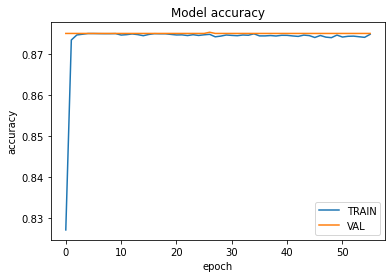

In [32]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

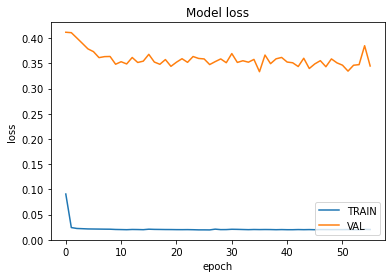

In [33]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [34]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.3443 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 8974.0000 - fn: 1282.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7630 - prc: 0.2229


Confusion matrix, without normalization

Classification Report for No Normalization:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       666
           2       0.00      0.00      0.00       317
           3       0.10      1.00      0.18       125
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        46
           6       0.27      0.75      0.40         8
           7       0.00      0.00      0.00        69

    accuracy                           0.10      1282
   macro avg       0.05      0.25      0.08      1282
weighted avg       0.01      0.10      0.02      1282



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


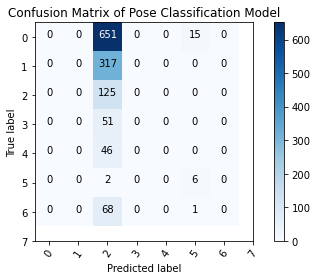

In [37]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report for No Normalization:\n', classification_report(y_true_label,
                                                          y_pred_label))

## Normalize everything

In [39]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 17, 3)        0           ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 17, 2)       0           ['reshape_3[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_9 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

 a)                                                                                               
                                                                                                  
 tf.math.multiply_12 (TFOpLambd  (None, 2)           0           ['tf.compat.v1.gather_12[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.broadcast_to_3 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_3[0][0]',       
                                                                  'tf.compat.v1.floor_div_3[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 2)           0           ['tf.math.multiply_13[0][0]',    
 mbda)    

In [40]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=['accuracy'],
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.SigmoidFocalCrossEntropyWithClassWeightsAllNorm"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
637/641 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.6636
Epoch 1: val_loss improved from -inf to 0.12713, saving model to weights.SigmoidFocalCrossEntropyWithClassWeightsAllNorm
INFO:tensorflow:Assets written to: weights.SigmoidFocalCrossEntropyWithClassWeightsAllNorm/assets
641/641 [==============================] - 4s 5ms/step - loss: 0.1958 - accuracy: 0.6642 - val_loss: 0.1271 - val_accuracy: 0.7730
Epoch 2/200
628/641 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.7567
Epoch 2: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.1446 - accuracy: 0.7578 - val_loss: 0.1062 - val_accuracy: 0.8097
Epoch 3/200
631/641 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.7799
Epoch 3: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.1309 - accuracy: 0.7791 - val_loss: 0.1031 - val_accuracy: 0.8307
Epo

633/641 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.8516
Epoch 30: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0869 - accuracy: 0.8515 - val_loss: 0.0672 - val_accuracy: 0.8994
Epoch 31/200
637/641 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.8502
Epoch 31: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0866 - accuracy: 0.8500 - val_loss: 0.0667 - val_accuracy: 0.8986
Epoch 32/200
633/641 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.8523
Epoch 32: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0867 - accuracy: 0.8529 - val_loss: 0.0645 - val_accuracy: 0.9048
Epoch 33/200
635/641 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.8580
Epoch 33: val_loss did not improve from 0.12713
641/641 [===========================

Epoch 60/200
639/641 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.8715
Epoch 60: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0764 - accuracy: 0.8715 - val_loss: 0.0596 - val_accuracy: 0.9111
Epoch 61/200
637/641 [============================>.] - ETA: 0s - loss: 0.0774 - accuracy: 0.8663
Epoch 61: val_loss did not improve from 0.12713
641/641 [==============================] - 2s 2ms/step - loss: 0.0772 - accuracy: 0.8665 - val_loss: 0.0580 - val_accuracy: 0.9080
Epoch 62/200
634/641 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.8714
Epoch 62: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0768 - accuracy: 0.8713 - val_loss: 0.0587 - val_accuracy: 0.9103
Epoch 63/200
617/641 [===========================>..] - ETA: 0s - loss: 0.0779 - accuracy: 0.8691
Epoch 63: val_loss did not improve from 0.12713
641/641 [==============

Epoch 90/200
623/641 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.8729
Epoch 90: val_loss did not improve from 0.12713
641/641 [==============================] - 2s 2ms/step - loss: 0.0744 - accuracy: 0.8731 - val_loss: 0.0545 - val_accuracy: 0.9150
Epoch 91/200
620/641 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.8760
Epoch 91: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0742 - accuracy: 0.8757 - val_loss: 0.0561 - val_accuracy: 0.9173
Epoch 92/200
636/641 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.8717
Epoch 92: val_loss did not improve from 0.12713
641/641 [==============================] - 2s 2ms/step - loss: 0.0748 - accuracy: 0.8718 - val_loss: 0.0561 - val_accuracy: 0.9119
Epoch 93/200
623/641 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.8731
Epoch 93: val_loss did not improve from 0.12713
641/641 [==============

641/641 [==============================] - 1s 2ms/step - loss: 0.0699 - accuracy: 0.8778 - val_loss: 0.0531 - val_accuracy: 0.9251
Epoch 120/200
638/641 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.8814
Epoch 120: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0714 - accuracy: 0.8809 - val_loss: 0.0528 - val_accuracy: 0.9189
Epoch 121/200
631/641 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.8780
Epoch 121: val_loss did not improve from 0.12713
641/641 [==============================] - 1s 2ms/step - loss: 0.0698 - accuracy: 0.8780 - val_loss: 0.0518 - val_accuracy: 0.9204
Epoch 122/200
638/641 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.8792
Epoch 122: val_loss did not improve from 0.12713
641/641 [==============================] - 2s 2ms/step - loss: 0.0707 - accuracy: 0.8796 - val_loss: 0.0551 - val_accuracy: 0.9158


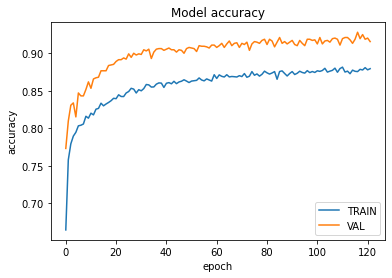

In [41]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

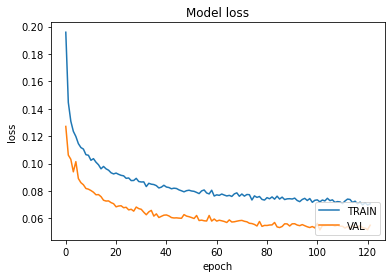

In [42]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [43]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.7083


Confusion matrix, without normalization

Classification Report for Normalization, Size and Position:
               precision    recall  f1-score   support

           1       0.98      0.66      0.79       666
           2       0.57      0.92      0.71       317
           3       0.64      0.79      0.71       125
           4       0.55      0.33      0.41        51
           5       0.73      0.52      0.61        46
           6       0.26      1.00      0.41         8
           7       0.40      0.46      0.43        69

    accuracy                           0.71      1282
   macro avg       0.59      0.67      0.58      1282
weighted avg       0.78      0.71      0.72      1282



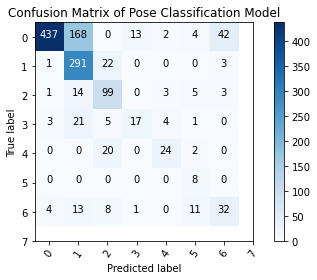

In [44]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report for Normalization, Size and Position:\n', classification_report(y_true_label,
                                                          y_pred_label))

## No normalizing size

In [45]:
def normalize_pose_landmarks_norescale(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_norescale(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [46]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 17, 3)        0           ['input_5[0][0]']                
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 17, 2)       0           ['reshape_4[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_18 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

In [47]:
model2.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.SigmoidFocalCrossEntropyWithClassWeightsNormSize"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)
# Start training
history2 = model2.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
618/641 [===========================>..] - ETA: 0s - loss: 0.8481 - accuracy: 0.3889
Epoch 1: val_loss improved from -inf to 0.22203, saving model to weights.SigmoidFocalCrossEntropyWithClassWeightsNormSize
INFO:tensorflow:Assets written to: weights.SigmoidFocalCrossEntropyWithClassWeightsNormSize/assets
641/641 [==============================] - 3s 4ms/step - loss: 0.8290 - accuracy: 0.3937 - val_loss: 0.2220 - val_accuracy: 0.5601
Epoch 2/200
622/641 [============================>.] - ETA: 0s - loss: 0.2636 - accuracy: 0.5502
Epoch 2: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.2633 - accuracy: 0.5496 - val_loss: 0.1982 - val_accuracy: 0.5671
Epoch 3/200
626/641 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.5788
Epoch 3: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.2324 - accuracy: 0.5781 - val_loss: 0.1736 - val_accuracy: 0.6303
E

632/641 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.7931
Epoch 30: val_loss did not improve from 0.22203
641/641 [==============================] - 2s 3ms/step - loss: 0.1240 - accuracy: 0.7930 - val_loss: 0.0876 - val_accuracy: 0.8534
Epoch 31/200
625/641 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.7931
Epoch 31: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.1206 - accuracy: 0.7922 - val_loss: 0.0804 - val_accuracy: 0.8877
Epoch 32/200
636/641 [============================>.] - ETA: 0s - loss: 0.1177 - accuracy: 0.8024
Epoch 32: val_loss did not improve from 0.22203
641/641 [==============================] - 2s 4ms/step - loss: 0.1175 - accuracy: 0.8027 - val_loss: 0.0834 - val_accuracy: 0.8674
Epoch 33/200
633/641 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.7978
Epoch 33: val_loss did not improve from 0.22203
641/641 [===========================

Epoch 60/200
619/641 [===========================>..] - ETA: 0s - loss: 0.1041 - accuracy: 0.8270
Epoch 60: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.1046 - accuracy: 0.8264 - val_loss: 0.0697 - val_accuracy: 0.8877
Epoch 61/200
635/641 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.8258
Epoch 61: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.1054 - accuracy: 0.8257 - val_loss: 0.0723 - val_accuracy: 0.8846
Epoch 62/200
617/641 [===========================>..] - ETA: 0s - loss: 0.1049 - accuracy: 0.8249
Epoch 62: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.1051 - accuracy: 0.8240 - val_loss: 0.0713 - val_accuracy: 0.8924
Epoch 63/200
615/641 [===========================>..] - ETA: 0s - loss: 0.1043 - accuracy: 0.8310
Epoch 63: val_loss did not improve from 0.22203
641/641 [==============

Epoch 90/200
634/641 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.8410
Epoch 90: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.0979 - accuracy: 0.8412 - val_loss: 0.0699 - val_accuracy: 0.8869
Epoch 91/200
636/641 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.8389
Epoch 91: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.0983 - accuracy: 0.8391 - val_loss: 0.0661 - val_accuracy: 0.9087
Epoch 92/200
641/641 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.8396
Epoch 92: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.0970 - accuracy: 0.8396 - val_loss: 0.0646 - val_accuracy: 0.9033
Epoch 93/200
628/641 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.8420
Epoch 93: val_loss did not improve from 0.22203
641/641 [==============

641/641 [==============================] - 1s 2ms/step - loss: 0.0958 - accuracy: 0.8466 - val_loss: 0.0663 - val_accuracy: 0.8955
Epoch 120/200
636/641 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.8418
Epoch 120: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.0961 - accuracy: 0.8420 - val_loss: 0.0641 - val_accuracy: 0.8986
Epoch 121/200
632/641 [============================>.] - ETA: 0s - loss: 0.0943 - accuracy: 0.8443
Epoch 121: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.0948 - accuracy: 0.8435 - val_loss: 0.0748 - val_accuracy: 0.8947
Epoch 122/200
635/641 [============================>.] - ETA: 0s - loss: 0.0947 - accuracy: 0.8412
Epoch 122: val_loss did not improve from 0.22203
641/641 [==============================] - 1s 2ms/step - loss: 0.0945 - accuracy: 0.8413 - val_loss: 0.0617 - val_accuracy: 0.9009
Epoch 123/200
640/641 [=========

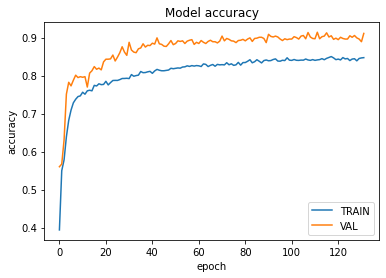

In [48]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

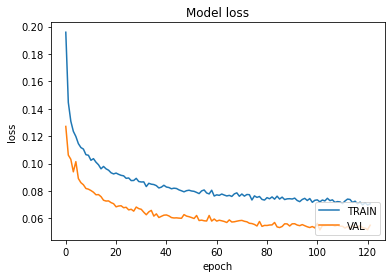

In [49]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [50]:
loss, accuracy = model2.evaluate(X_test, y_test)

41/41 [==============================] - 0s 1ms/step - loss: 0.0733 - accuracy: 0.8838


## No normalizing position

In [ ]:
def normalize_pose_landmarks_noreposition(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
   # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_noreposition(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

In [ ]:
model2.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.SigmoidFocalCrossEntropyWithClassWeightsNoNormPos"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history2 = model2.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

In [ ]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [ ]:
loss, accuracy = model2.evaluate(X_test, y_test)

In [ ]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))